In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
import cv2
import math
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from collections import Counter
from tqdm import tqdm

### The data is stored inside the 'team' directory

In [2]:
# Set path for training images
filepaths_go = [f for f in listdir("../GO_noGO Data Set_Images/TestGo") if f.endswith('.png')]
filepaths_nogo = [f for f in listdir("../GO_noGO Data Set_Images/TestNoGo") if f.endswith('.png')]

path_generated_go = '../GO_noGO Data Set_Images/TestGo/'
path_generated_nogo = '../GO_noGO Data Set_Images/TestNoGo/'

In [3]:
# Read all GO and NoGO images into a list
list_img = []
for i in tqdm(filepaths_go):
    list_img.append(cv2.imread(path_generated_go + i))

100%|██████████| 3370/3370 [00:19<00:00, 173.83it/s]


In [4]:
for i in tqdm(filepaths_nogo):
    list_img.append(cv2.imread(path_generated_nogo + i))

100%|██████████| 5000/5000 [00:33<00:00, 150.38it/s]


In [5]:
n = len(list_img)

In [8]:
n

8370

### Feature Extraction class

In [9]:
class Feature_Extractor:
    # class defines feature extraction methods for extracting features out of an image
    def __init__(self, threshold = 200, line_margin = 15, roof_margin = 10, corner_margin = 5):
        self.threshold = threshold
        self.line_margin = line_margin
        self.roof_margin = roof_margin
        self.corner_margin = corner_margin

    def img_width(self, img):
        return img.shape[1]
    
    def img_height(self, img):
        return img.shape[0]

    def count_level(self, img):
        # Function that counts the number of floors
        # Convert img to grayscale
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Get shape
        shape = gray.shape

        # Get width of the image
        width = shape[1]

        # Detect edges
        edges = cv2.Canny(gray, 80, 120)

        #HoughLinesP returns an array of (rho, theta) values. 
        #rho is measured in pixels and theta is measured in radians

        # Detect lines representing the floors which are longer than 80% of the width of the building
        lines = cv2.HoughLinesP(edges, rho = 1, theta = math.pi/2, minLineLength = 0.8*width, threshold = 1, maxLineGap = 3)
        
        flags = [0]
        if (type(lines) != type(None)):
            lines.tolist()

            # Delete repeated lines and line detected from the roof (we only need floor lines to count the number of floors)

            flags = [0]*len(lines)  # flags will mark the redundant lines as 1, lines we need as 0
            for i in range(len(lines)):
                for j in range(len(lines)):
                    if j < i and (abs(lines[i][0][1]-lines[j][0][1]) < self.line_margin):  # detect lines very close to each other 
                        flags[j] = 1
                if abs(lines[i][0][1]-0) < self.roof_margin:  # roof lines: y Coordinate -> 0
                    flags[i] = 1
        counter = 0
        for i in range(len(flags)):
            if flags[i] == 0:
                counter += 1                
        return counter

    def count_openings(self, img):
        # Function that counts the number of openings in a house
        # most of the openings are white rectangles which denote windows and gates
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret,thresh = cv2.threshold(gray, self.threshold, 255, 0)
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        quadrilaterals = []
        for i in range(len(contours)):
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 
        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        redflag = [0]*len(quadrilaterals)

        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - width) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        return (len(quadrilaterals) - np.sum(redflag))

    def fraction_width(self, img):
        # Function that calculates proportion of sum of all windows' widths (without overlap), on all floors 
        # to the overall wigth of building
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - width) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # Get a blank canvas for drawing width of a side of each quadrilateral
        detection_series = np.zeros(width, dtype = 'uint8')

        # The width of a side should be the larger x cordinate of the right vertics 
        # minus the x cordinate of the left vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                x_min = np.min(q[:,0,0])
                x_max = np.max(q[:,0,0])
                detection_series[x_min:x_max] = np.ones(x_max-x_min, dtype = 'uint8')

        # Return fraction of sum of all windows' widths (without overlap), on all floors to the overall width of building
        return np.sum(detection_series)/width
    
    def avg_fraction_width(self, img):
        # Function that calculates proportion of sum of all windows' widths (divided by the number of floors) 
        # to the overall length of building

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - width) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # set aggregate width = 0 before the loop that is going to account for the width of each opening
        aggregate_width = 0;

        # The width of a side should be the larger x cordinate of the right vertics 
        # minus the x cordinate of the left vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                x_min = np.min(q[:,0,0])
                x_max = np.max(q[:,0,0])
                aggregate_width = aggregate_width + (x_max-x_min)

        # now in order to calculate the average, we need the number of floors
        num_levels = self.count_level(img)

        # Return the ratio of: average of sum of all windows' widths (over all floors) to the total width of the building
        return aggregate_width/(num_levels*width)
    
    def fraction_height(self, img):
        # Function that calculates proportion of sum of all windows' heights (without overlap), on all floors
        # to the overall length of building
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - gray.shape[1]) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # Get a blank canvas for drawing width of a side of each quadrilateral
        detection_series = np.zeros(height, dtype = 'uint8')

        # The height of a side should be the larger y cordinate of the top vertics 
        # minus the y cordinate of the bottom vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                y_min = np.min(q[:,0,1])
                y_max = np.max(q[:,0,1])
                detection_series[y_min:y_max] = np.ones(y_max-y_min, dtype = 'uint8')

        # Return fraction of sum of all windows' heights (without overlap), on all floors to the overall length of building
        return np.sum(detection_series)/height
    
    def aggregate_fraction_height(self, img):
        # Function that calculates proportion of sum of all windows' heights (divided by the number of floors) 
        # to the overall length of building
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height = gray.shape[0]
        width = gray.shape[1]

        # threshold optimized (via hit and trial) for the generated images
        ret, thresh = cv2.threshold(gray, self.threshold, 255, 0)

        # Contours is a tree of lists of points which describe each contour
        contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a list storing quadrilaterals that represent openings
        quadrilaterals = []
        for i in range(len(contours)):

            # Contour approximation will mark four vertices of a quadrilateral
            polygon = cv2.approxPolyDP(contours[i],0.01*cv2.arcLength(contours[i],True),True)
            # filtering only those openings that are quadrilaterals
            if len(polygon) == 4:
                quadrilaterals.append(polygon) 

        redflag = [0]*len(quadrilaterals)

        # Detect and delete quadrilaterals outside the house which should not be counted as openings
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            for j in range(4):
                if abs(q[j][0][0] - gray.shape[1]) < self.corner_margin or abs(q[j][0][0]) < self.corner_margin:
                    redflag[i] = 1

        # set aggregate height = 0 before the loop that is going to account for the height of each opening
        aggregate_height = 0

        # The height of a side should be the larger y cordinate of the top vertics 
        # minus the y cordinate of the bottom vertics
        for i in range(len(quadrilaterals)):
            q = quadrilaterals[i]
            if redflag[i]!=1:
                y_min = np.min(q[:,0,1])
                y_max = np.max(q[:,0,1])
                aggregate_height = aggregate_height + (y_max-y_min)

        # To be careful:
        # Width of each floor is same and equal to the width of the house
        # However, height of each floor = height of the house / 3
        # So we actually don't need the number of floors to calculate the average

        # there is no notion of vertical floors, so this ratio is going to exceed one
        # Return the ratio of: sum of all windows' height to the total height of the building
        return aggregate_height/height


### Processing feature vectors for all the images

In [10]:
feature_extractor = Feature_Extractor()

In [11]:
# Create a list called 'levels' to store number of floors for each building
levels = []
for i in tqdm(range(n)):
    n_level = feature_extractor.count_level(list_img[i])
    levels.append(n_level)

100%|██████████| 8370/8370 [00:47<00:00, 176.29it/s]


In [12]:
Counter(levels)

Counter({1: 2036, 2: 2536, 3: 3763, 4: 35})

In [13]:
# Create a list called 'openings' to store number of openings
openings = []
for i in tqdm(range(n)):
    openings.append(feature_extractor.count_openings(list_img[i]))

100%|██████████| 8370/8370 [00:43<00:00, 193.55it/s]


In [15]:
Counter(openings)

Counter({2: 1475,
         4: 1056,
         1: 628,
         6: 1791,
         3: 1654,
         5: 389,
         7: 276,
         8: 220,
         9: 881})

In [16]:
# Create a list called 'fraction_widths' to store proportion of sum of all windows' widths (without overlap), (on all floors) 
# to the overall width of building
fraction_widths = []
for i in tqdm(range(len(list_img))):
    fraction_widths.append(feature_extractor.fraction_width(list_img[i]))

100%|██████████| 8370/8370 [00:44<00:00, 187.58it/s]


In [17]:
# Create a list called 'avg_fraction_widths' to store proportion of average of all windows' widths (over all floors) 
# to the overall width of building
avg_fraction_widths = []
for i in tqdm(range(len(list_img))):
    avg_fraction_widths.append(feature_extractor.avg_fraction_width(list_img[i]))

100%|██████████| 8370/8370 [01:02<00:00, 134.88it/s]


In [18]:
# Create a list called 'fraction_heights' to store proportion of sum of all windows' heights (without overlap), on all floors 
# to the overall height of building
fraction_heights = []
for i in tqdm(range(len(list_img))):
    fraction_heights.append(feature_extractor.fraction_height(list_img[i]))

100%|██████████| 8370/8370 [00:47<00:00, 175.68it/s]


In [19]:
# Create a list called 'aggregate_fraction_heights' to store proportion of sum of all windows' heights (on all floors) 
# to the overall height of building
aggregate_fraction_heights = []
forz i in tqdm(range(len(list_img))):
    aggregate_fraction_heights.append(feature_extractor.aggregate_fraction_height(list_img[i]))

100%|██████████| 8370/8370 [00:47<00:00, 177.39it/s]


In [20]:
# Create a list called 'img_widths' to store the pixel widths of all images
img_widths = []
for i in tqdm(range(len(list_img))):
    img_widths.append(feature_extractor.img_width(list_img[i]))

100%|██████████| 8370/8370 [00:00<00:00, 19667.06it/s]


In [22]:
# Create a list called 'img_heights' to store the pixel widths of all images
img_heights = []
for i in tqdm(range(len(list_img))):
    img_heights.append(feature_extractor.img_height(list_img[i]))

100%|██████████| 8370/8370 [00:00<00:00, 637670.73it/s]


In [23]:
# Extract image index (four digit number)
files_go_idx = []
for file in filepaths_go:
    files_go_idx.append(int(file.split("Img")[1].split(".")[0]))
files_go_idx[:10]

[6081, 1936, 6095, 6903, 8090, 8084, 333, 6917, 6724, 6042]

In [24]:
files_nogo_idx = []
for file in filepaths_nogo:
    if "Img" in file:
        files_nogo_idx.append(int(file.split("Img")[1].split(".")[0]))
files_nogo_idx[:10]

[1088, 3847, 2581, 4696, 5588, 469, 1922, 4682, 3853, 2595]

In [25]:
files = files_go_idx + files_nogo_idx

In [26]:
# Create a a dataframe with all features and image index as columns
dic = {"filename":files, "levels":levels, "openings":openings, "fraction_widths":fraction_widths, 
       "avg_fraction_widths":avg_fraction_widths, "fraction_heights":fraction_heights, 
       "aggregate_fraction_heights":aggregate_fraction_heights, "img_widths":img_widths, "img_heights":img_heights}
df = pd.DataFrame(dic)

In [27]:
df.head()

,filename,levels,openings,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights
0,6081,1,2,0.182203,0.182203,0.402062,0.582474,472,194
1,1936,2,2,0.099812,0.077213,0.403333,0.403333,531,300
2,6095,2,4,0.303202,0.151601,0.447531,0.734568,531,324
3,6903,1,1,0.088136,0.088136,0.446602,0.446602,590,206
4,8090,2,2,0.111864,0.079661,0.400000,0.400000,590,300


In [28]:
# Add GO/NoGo column to label each image
df['Go/NoGo']=df['filename'].apply(lambda x: 1 if x in files_go_idx else 0)

In [29]:
df.head()

,filename,levels,openings,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights,Go/NoGo
0,6081,1,2,0.182203,0.182203,0.402062,0.582474,472,194,1
1,1936,2,2,0.099812,0.077213,0.403333,0.403333,531,300,1
2,6095,2,4,0.303202,0.151601,0.447531,0.734568,531,324,1
3,6903,1,1,0.088136,0.088136,0.446602,0.446602,590,206,1
4,8090,2,2,0.111864,0.079661,0.400000,0.400000,590,300,1


### Fitting in logistic model and evaluate the performance(accuracy)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc [:, 1:9] , df['Go/NoGo'], test_size=0.3, random_state=0)

In [31]:
## normalizing the feature vectors
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [32]:
## hyperparameter tuning
logreg = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
# balanced weights for class imbalance
penalty = ['l1', 'l2']
C =np.logspace(-2, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

In [33]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [34]:
best_model = clf.fit(X_train_scaled, y_train)

In [35]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.046415888336127774


In [36]:
y_pred = best_model.predict(X_test_scaled)

In [37]:
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(100*best_model.score(X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 80.45%


In [39]:
## Confustion Matrix
confusion_matrix(y_test, y_pred)

array([[1221,  293],
       [ 198,  799]])

### xgboost feature significance

In [40]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from copy import copy

In [59]:
# XGBoost doesn't (yet) handle categorical features automatically, so need to change
# them to columns of integer values.

## encode string class values as integers
# le = LabelEncoder()
# le = le.fit(df_model["category"])
# df_model["category"] = le.transform(df_model["category"])

# split data into X and Y
X = df.iloc[:,1:9]
Y = df.iloc[:,9]

## encode string class values as integers
# le = LabelEncoder()
# label_encoder = le.fit(Y)
# label_encoded_y = le.transform(Y)

In [60]:
seed = 1234
test_size = 0.20

# train/test split
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size=test_size, random_state=seed)

In [61]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [62]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.78%


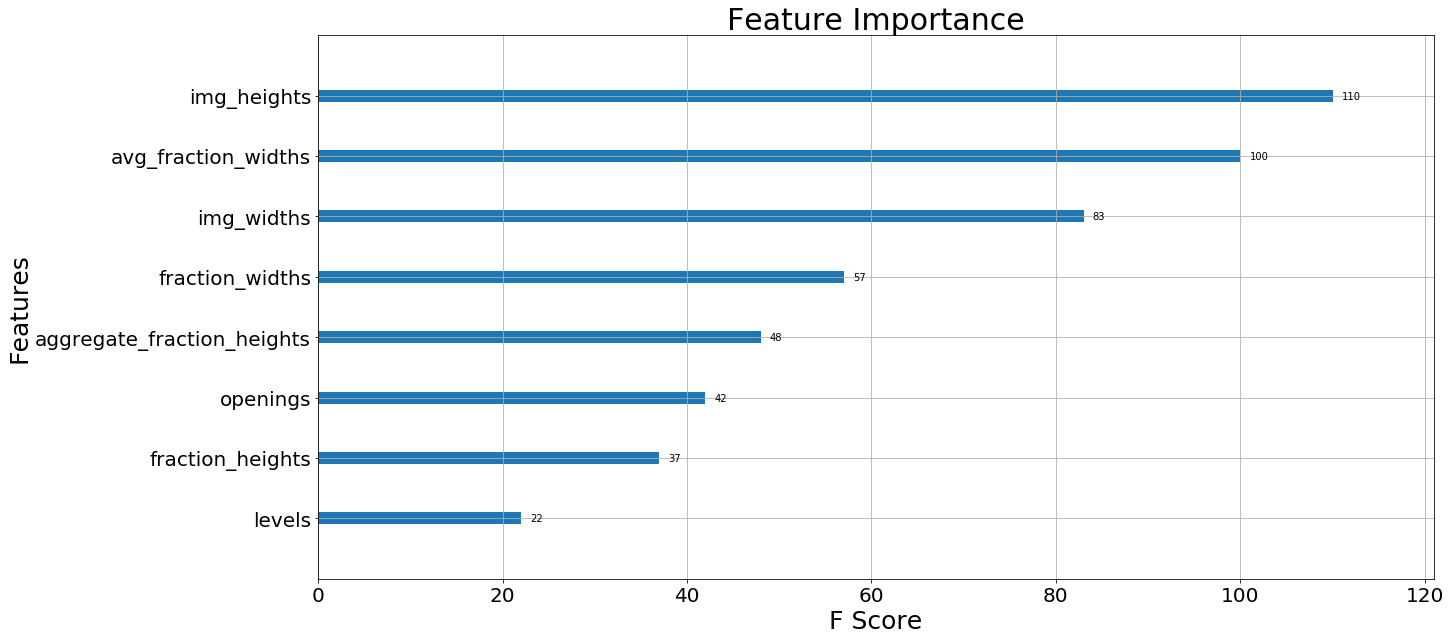

In [63]:
# feature importance use built-in XGBoost Feature Importance Plot
fig, ax = plt.subplots(1,1,figsize=(20,10))
xgb.plot_importance(model, ax=ax)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("F Score", fontsize=25)
plt.ylabel("Features", fontsize=25)
plt.title('Feature Importance', fontsize=30)
fig.savefig('featureInportance1.png')
plt.show()

### refit the logistic model: drop img_heights

In [ ]:
df.drop[]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc [:, 1:8] , df['Go/NoGo'], test_size=0.3, random_state=0)
## normalizing the feature vectors
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [49]:
## hyperparameter tuning
logreg = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
# balanced weights for class imbalance
penalty = ['l1', 'l2']
C =np.logspace(-2, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

In [50]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train_scaled, y_train)

In [51]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 4.6415888336127775


In [52]:
y_pred = best_model.predict(X_test_scaled)

In [53]:
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(100*best_model.score(X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 79.61%


In [ ]:
## Confustion Matrix
confusion_matrix(y_test, y_pred)